# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

In [3]:
#Загружаем данные
geo = pd.read_excel('geo.xlsx')
geo_comment = pd.read_excel('geo_comment.xlsx')

In [4]:
#Смотрим, что загрузилось
geo.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [5]:
#смотрим информацию
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


In [6]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [7]:
#Проводим нормализацию данных
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
geo_scaled = scaler.fit_transform(geo)

### Kmeans

Посмотрим, как Kmeans разобьет наши данные на 10 кластеров

In [10]:
n_clusters = 10

In [11]:
kmeans = KMeans(n_clusters=n_clusters)

In [12]:
kmeans.fit(geo_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [13]:
cluster_labels = kmeans.predict(geo_scaled)

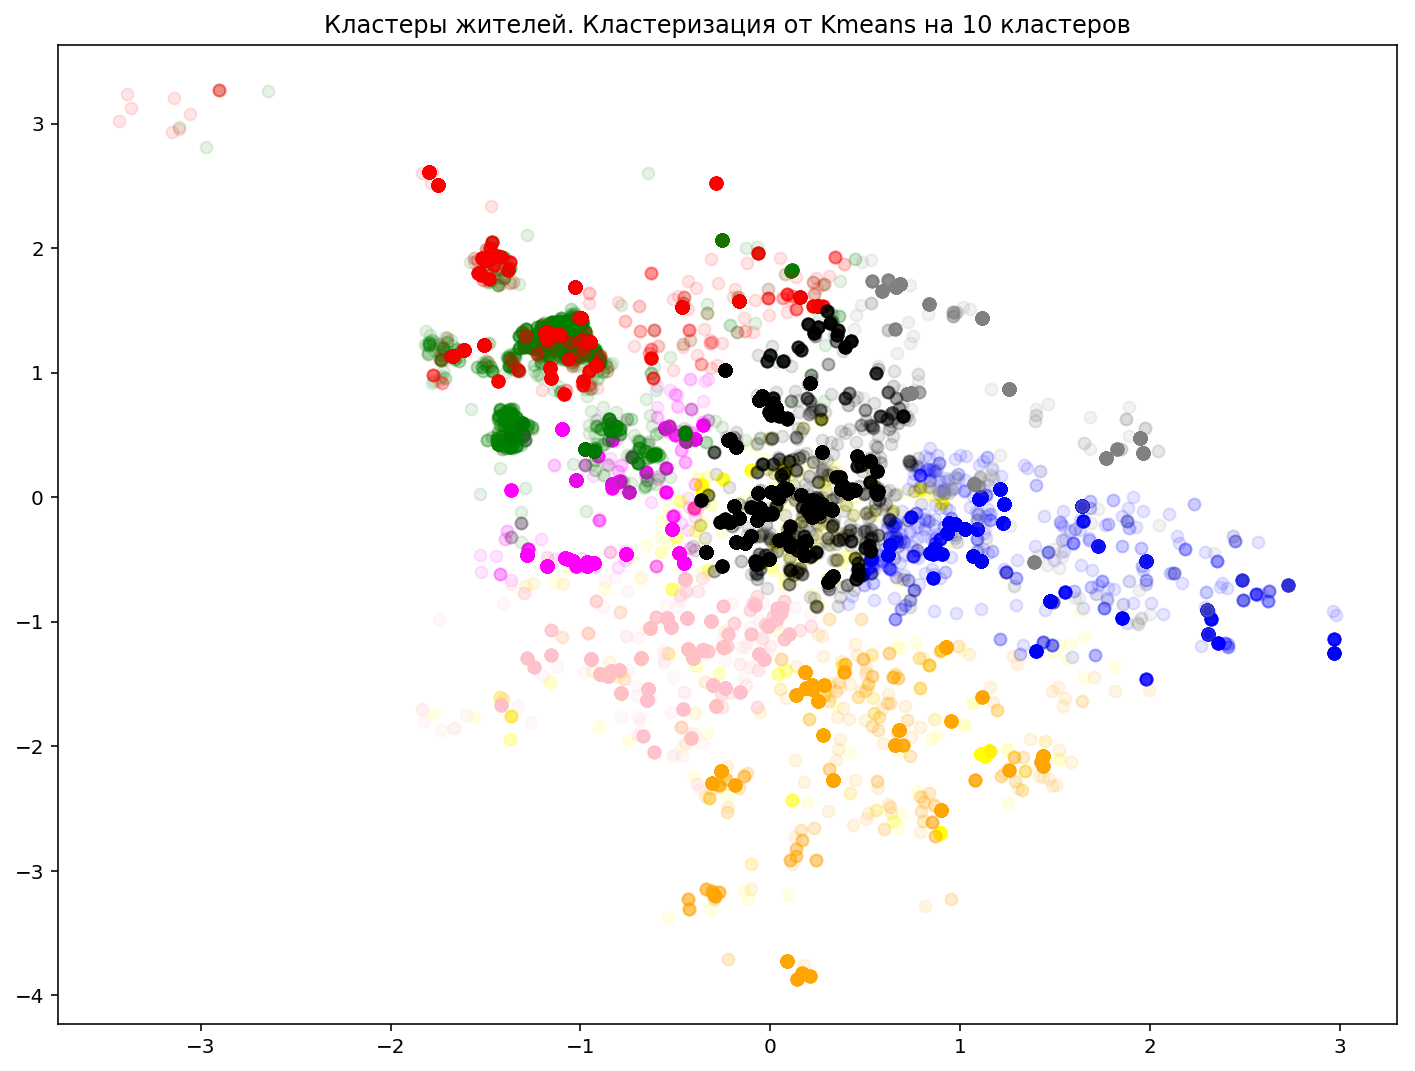

In [14]:
plt.title('Кластеры жителей. Кластеризация от Kmeans на 10 кластеров')
for i,color in zip(range(n_clusters),{'blue','red','green','black','orange','yellow', 'gray', 'magenta', 'pink'}):
    t = geo_scaled[cluster_labels==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)

### Подбор оптимального количества кластеров для Kmeans

In [15]:
#Посмотрим, как ведет себе Kmeans при изменении количества кластеров от 1 до 20
k_inertia = []
ks = range(1,20)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(geo_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

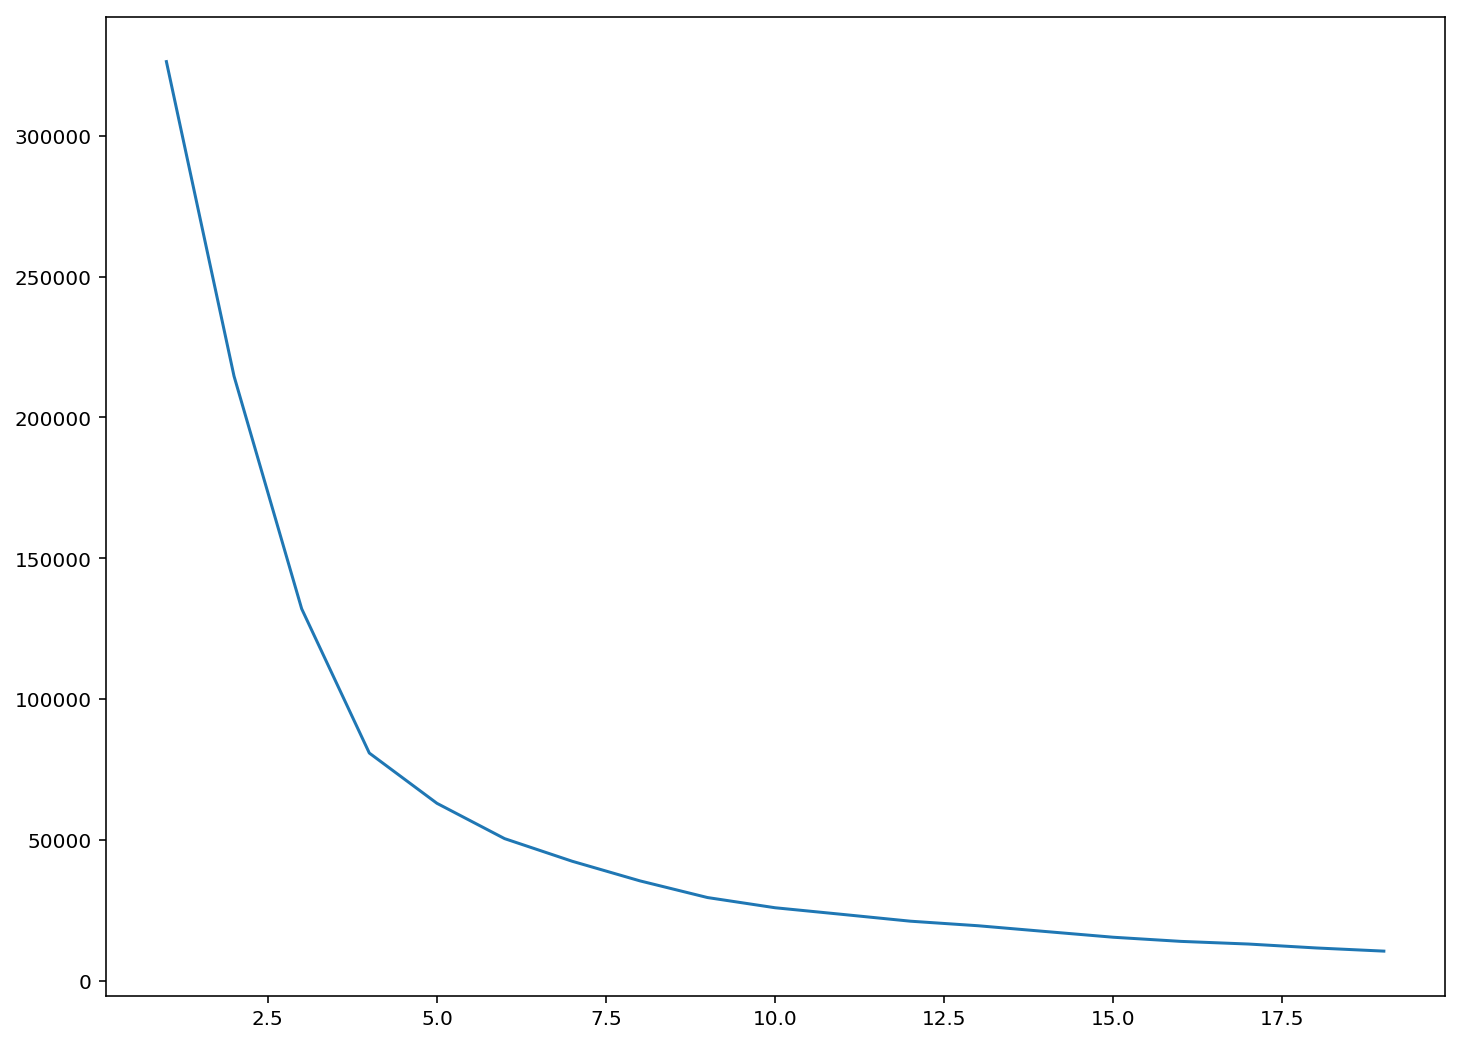

In [16]:
plt.plot(ks, k_inertia)

In [17]:
#Считаем изменения значения на каждом шаге
diff = np.diff(k_inertia)

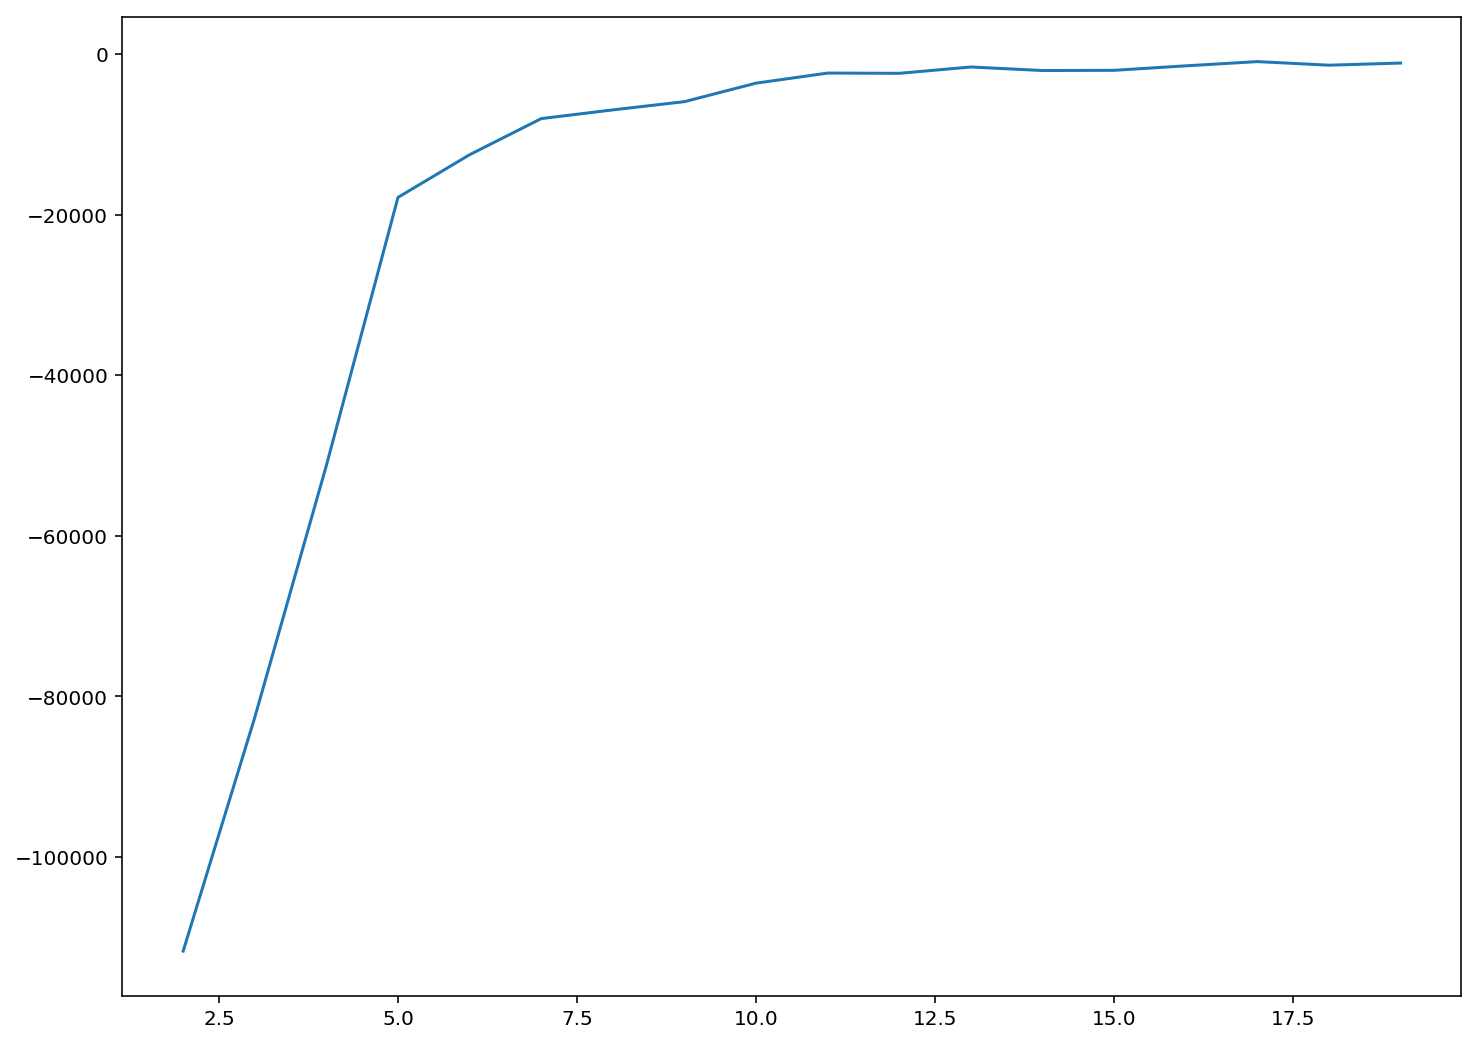

In [18]:
#Выведем изменения на экран
plt.plot(ks[1:], diff)

Теперь можно найти оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [19]:
diff_r = diff[1:] / diff[:-1]

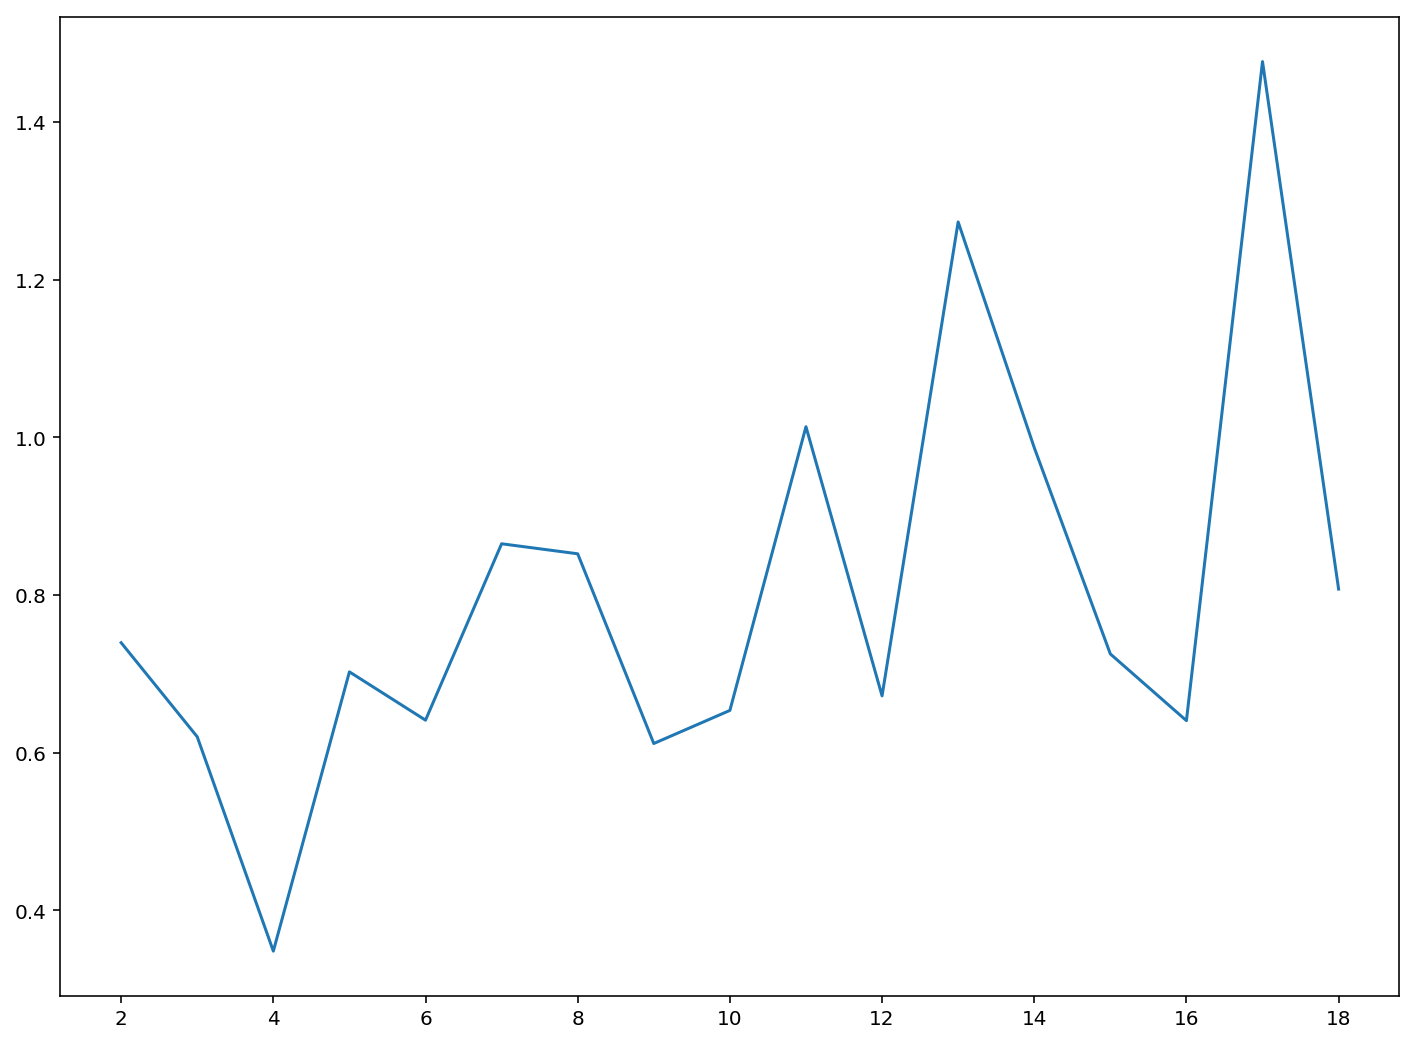

In [20]:
#Выведем изменения на экран
plt.plot(ks[1:-1], diff_r)

In [21]:
#Вычислим оптимальное значение
k_opt = ks[np.argmin(diff_r)+1]
k_opt

4

In [22]:
n_clusters=k_opt

In [23]:
#Нарисуем оптимальное разбиение
kmeans = KMeans(n_clusters=n_clusters)

In [24]:
kmeans.fit(geo_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
cluster_labels = kmeans.predict(geo_scaled)

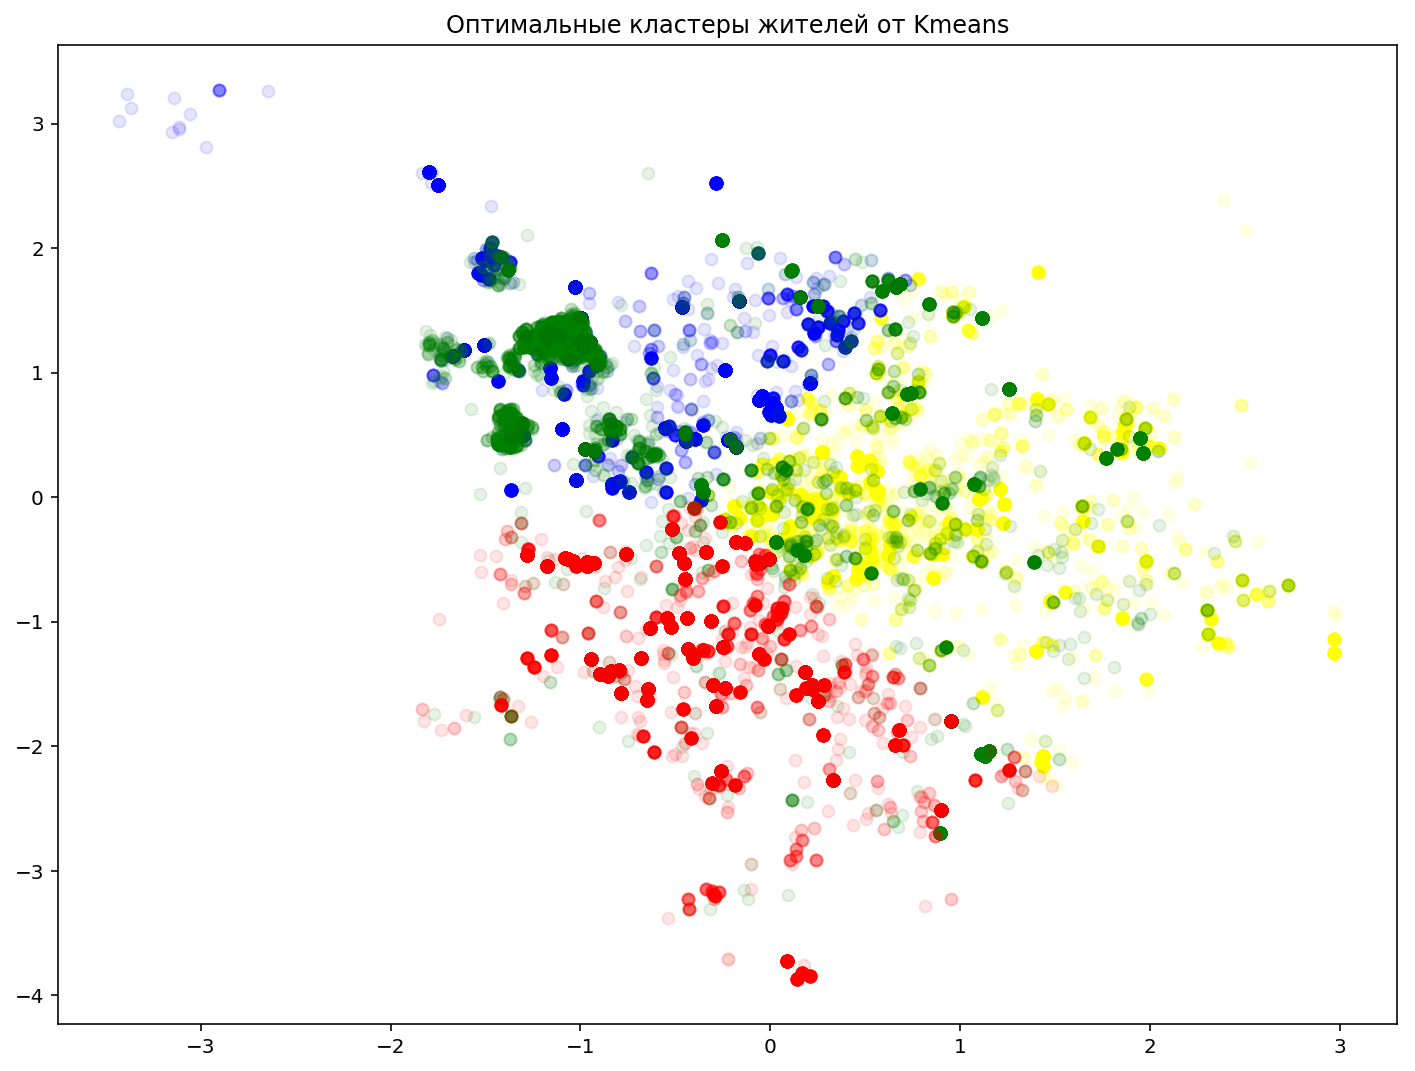

In [26]:
plt.title('Оптимальные кластеры жителей от Kmeans')
for i,color in zip(range(n_clusters),{'blue','red','green','black','orange','yellow'}):
    t = geo_scaled[cluster_labels==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)

### DBSCAN

Попробуем разбить наши данные на кластеры при помощи DBSCAN

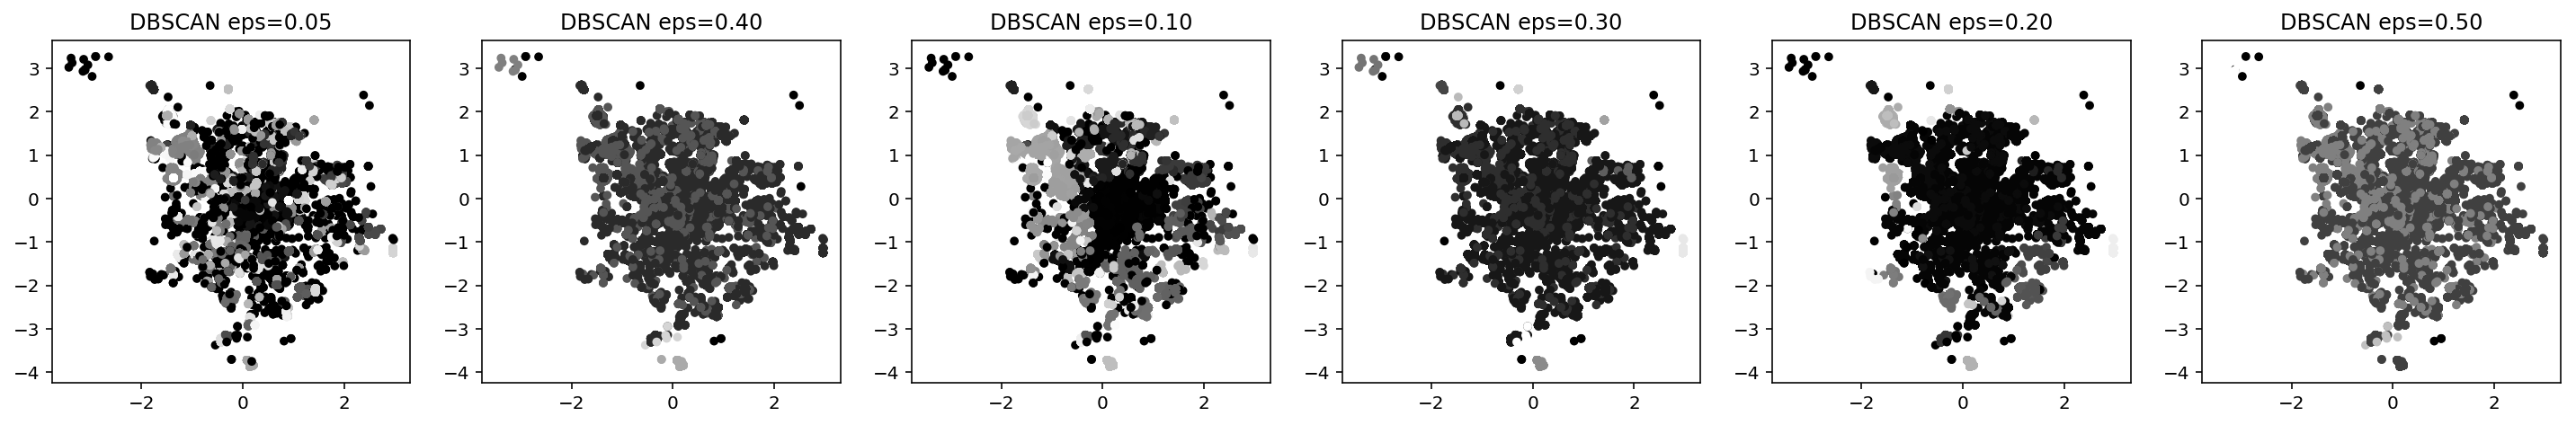

In [27]:
fig, axes = plt.subplots(1, 6, figsize=(25, 3.5))
#Выведем рисунки кластеров полученные DBSCAN для разных значений eps
eps = {0.05, 0.1, 0.2, 0.3, 0.4, 0.5}
for ax, e in zip(axes[0:], eps):
    # кластеризуем и выводим картинку
    DBS=DBSCAN(eps=e, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
    clusters_DBS=DBS.fit_predict(geo_scaled)
    ax.scatter(geo_scaled[:,0], geo_scaled[:,1], c=clusters_DBS, cmap='gray', s=15)
    ax.set_title('DBSCAN eps={0:.2f}'.format(e))

In [28]:
DBS=DBSCAN(eps=0.25, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=-1)

In [29]:
DBS.fit(geo_scaled)

DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=-1, p=None)

In [30]:
clusters_DBS=DBS.fit_predict(geo_scaled)

In [31]:
print(clusters_DBS.max())

20


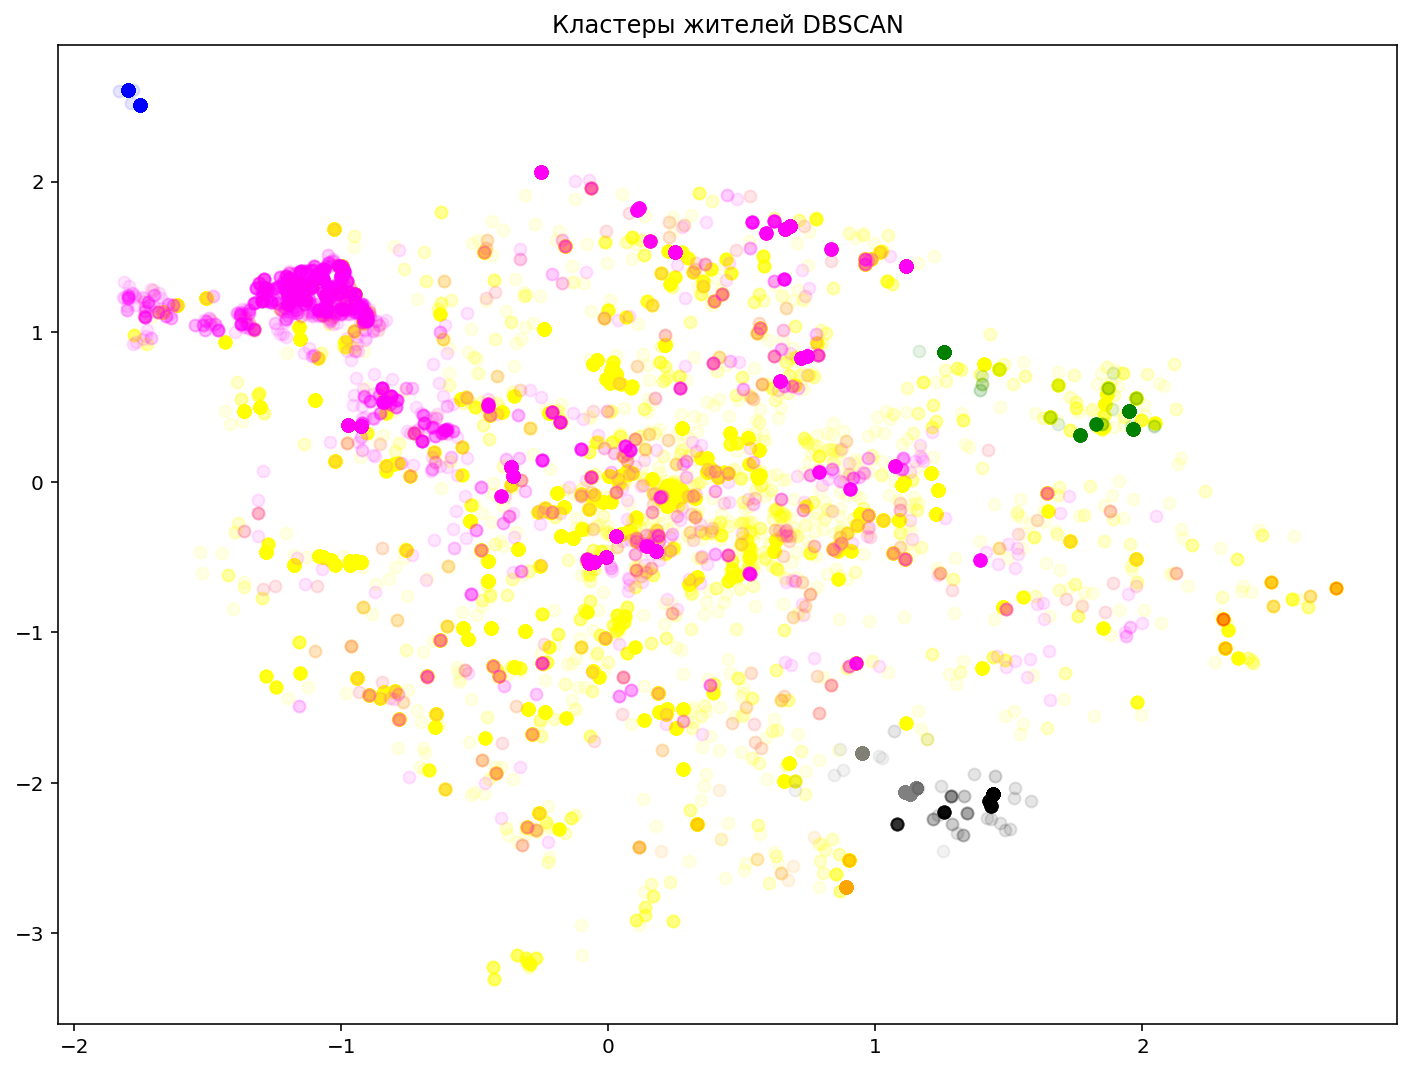

In [32]:
plt.title('Кластеры жителей DBSCAN')
for i,color in zip(range(clusters_DBS.max()),{'blue','red','green','black','orange','yellow', 'gray', 'magenta'}):
    t = geo_scaled[clusters_DBS==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)

### Agglomerative  Clustering

In [33]:
n_clusters=7

In [34]:
AG=AgglomerativeClustering(n_clusters=n_clusters)

In [35]:
cluster_AG=AG.fit_predict(geo_scaled)

MemoryError: unable to allocate array data.

In [ ]:
plt.title('Кластеры жителей')
for i,color in zip(range(n_clusters),{'blue','red','green','black','orange','yellow'}):
    t = geo_scaled[cluster_AG==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)

### AffinityPropagation

In [ ]:
AP=AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', 
                       verbose=False)

In [ ]:
cluster_AP=AP.fit_predict(geo_scaled)

In [ ]:
plt.title('Кластеры жителей')
for i,color in zip(range(clusters_AP.max()),{'blue','red','green','black','orange','yellow'}):
    t = geo_scaled[cluster_AP==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)